**学号：** 2310650118  &nbsp; **姓名：** 洪菁曼  &nbsp; **班级：** 信息2301 

# 报告3 聚类实验

对数据集`wholesale_customers.csv`进行聚类分析。

### 提交要求：
1. 填写Word版实验报告表格；
2. 提交jupyter笔记和该笔记PDF；
3. 文件名格式示例：
   * `学号-姓名-实验报告.docx`
   * `学号-姓名-实验笔记.ipynb`
   * `学号-姓名-实验笔记.pdf`

> 学委收齐，整理在一个文件夹内，打包发给我。

<br>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

### 1. 数据读取与预处理


In [27]:
df = pd.read_csv("../datasets/wholesale_customers.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [28]:
X = df.iloc[:, 2:8].copy()
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(440, 6)

### 2. 聚类分析

#### 基于PCA的K-means聚类

In [29]:
pca = PCA()
pcs = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)
pcs


[0.44082893 0.283764   0.12334413 0.09395504 0.04761272 0.01049519]


array([[ 0.19329055, -0.30509996,  0.14087845, -0.48643154,  0.49528148,
        -0.00741414],
       [ 0.4344199 , -0.32841262, -0.31900662, -0.17883036,  0.36557931,
         0.05457185],
       [ 0.81114323,  0.8150957 , -1.52341562, -1.25408154, -0.37905353,
        -0.27753858],
       ...,
       [ 3.46570362, -1.03983801,  0.71316141,  0.0334078 , -0.53876786,
        -0.08534909],
       [-0.91802273, -0.03004659, -0.25840805, -0.52457824, -0.09321487,
        -0.028943  ],
       [-1.10513709, -0.86133787, -0.30515404, -0.11437678,  0.10990335,
         0.02897846]])

In [30]:
pca.components_

array([[ 0.04288396,  0.54511832,  0.57925635,  0.05118859,  0.5486402 ,
         0.24868198],
       [ 0.52793212,  0.08316765, -0.14608818,  0.61127764, -0.25523316,
         0.50420705],
       [ 0.81225657, -0.06038798,  0.10838401, -0.17838615,  0.13619225,
        -0.52390412],
       [-0.23668559, -0.08718991,  0.10598745,  0.76868266,  0.17174406,
        -0.55206472],
       [-0.04868278,  0.82657929, -0.31499943, -0.02793224, -0.33964012,
        -0.31470051],
       [-0.03602539, -0.03804019,  0.72174458, -0.01563715, -0.68589373,
        -0.07513412]])


--- 主成分与原始特征的关系 (PCA Components) ---
        Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
PC1  0.042884  0.545118  0.579256  0.051189          0.548640    0.248682
PC2  0.527932  0.083168 -0.146088  0.611278         -0.255233    0.504207
PC3  0.812257 -0.060388  0.108384 -0.178386          0.136192   -0.523904
PC4 -0.236686 -0.087190  0.105987  0.768683          0.171744   -0.552065
PC5 -0.048683  0.826579 -0.314999 -0.027932         -0.339640   -0.314701
PC6 -0.036025 -0.038040  0.721745 -0.015637         -0.685894   -0.075134


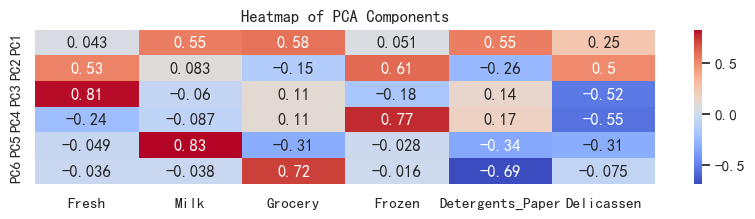

In [31]:
feature_names = [f'PC{i+1}' for i in range(pca.components_.shape[0])]
print("\n--- 主成分与原始特征的关系 (PCA Components) ---")
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=feature_names)
print(components_df)

plt.figure(figsize=(10, 2))
sns.heatmap(components_df, cmap='coolwarm', annot=True)
plt.title('Heatmap of PCA Components')
plt.show()

* PC1：以milk、grocery、detergents_paper为主要正载荷
* PC2：以fresh、forzen、delicassen为主要正载荷
* PC5：以milk为主要正载荷，grocery、detergents_paper、delicassen为主要负载荷
* PC3：以fresh为主要正载荷，delicassen为主要负载荷


--- K-Means 聚类 ---


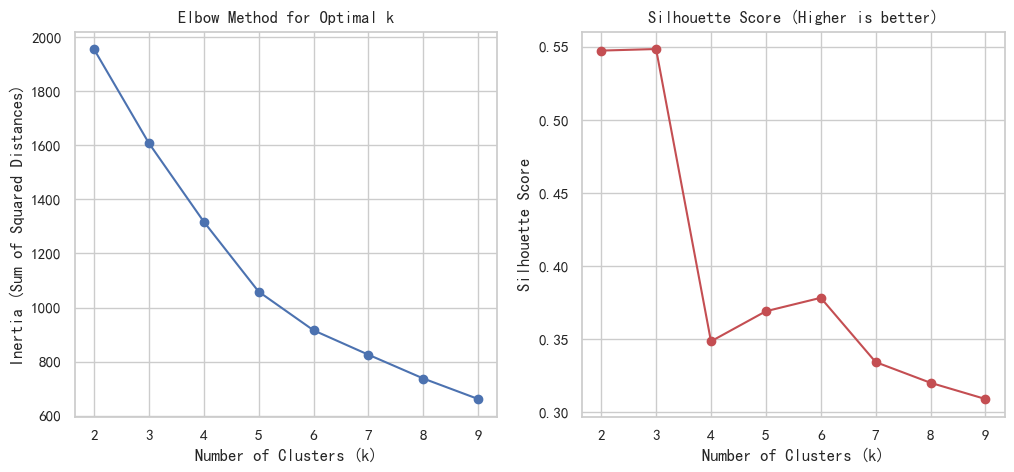


选用 k=3 进行聚类...


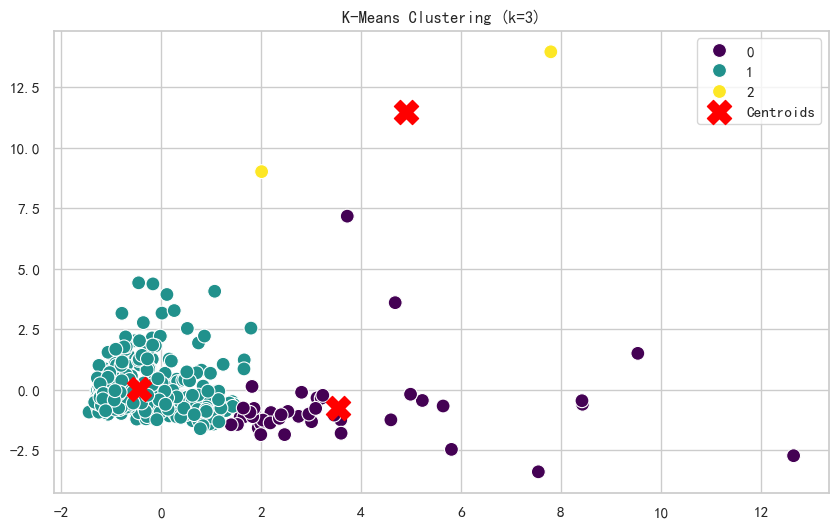

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("\n--- K-Means 聚类 ---")
# --- 第一步：手肘法寻找最佳 K 值 ---
inertia = []
silhouette_scores = []
K_range = range(2, 10)  # 尝试 2 到 9 个簇

for k in K_range:
    # 随机种子 random_state 保证结果可复现
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pcs) # 这里既可以用 X_pca，也可以用原始标准化数据 X_scaled
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pcs, kmeans.labels_))

# 绘制手肘图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score (Higher is better)')
plt.show()

# --- 第二步：根据上图选择 K 值进行最终聚类 ---
# 假设根据图看，k=3 或 k=4 比较合适（拐点位置或轮廓系数最高点）
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]  # <--- 如果你觉得 3 合适，就改成 3
print(f"\n选用 k={best_k} 进行聚类...")

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(pcs)

# 将结果存入 DataFrame
df['Cluster_K'] = clusters

# 可视化结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=clusters, palette='viridis', s=100)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], 
            s=300, c='red', marker='X', label='Centroids') # 标记质心
plt.title(f'K-Means Clustering (k={best_k})')
plt.legend()
plt.show()

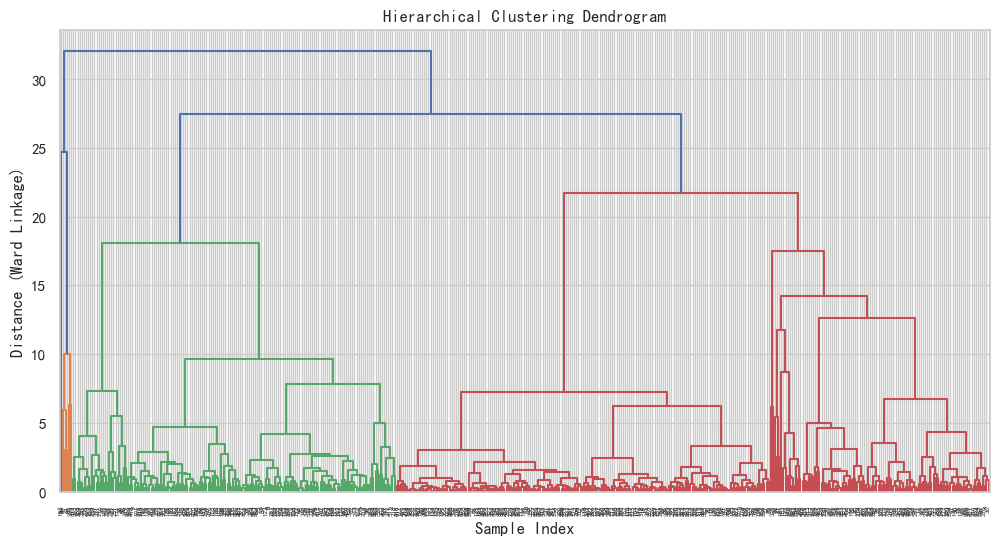

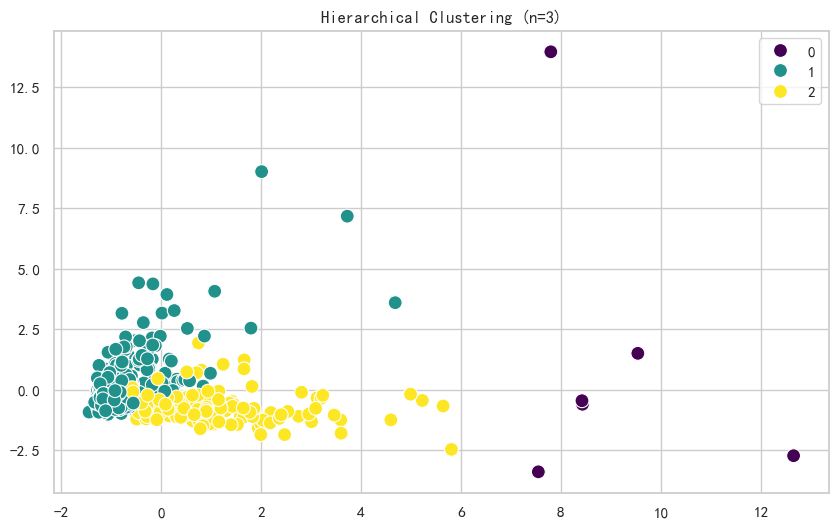

In [34]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# --- 第一步：绘制树状图 (Dendrogram) ---
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance (Ward Linkage)')

# 使用 ward 连接法，最小化簇内方差
dendrogram = sch.dendrogram(sch.linkage(pcs, method='ward'))
# 如果想画一条水平线辅助切分，可以加这行：
# plt.axhline(y=20, color='r', linestyle='--') 
plt.show()

# --- 第二步：根据树状图切分聚类 ---
# 观察树状图，看最长的纵向线条在哪里被横线切断最合适
# n_clusters 是你想保留的簇数量
n_clusters_hc = 3 

hc = AgglomerativeClustering(n_clusters=n_clusters_hc, linkage='ward')
clusters = hc.fit_predict(pcs)

# 将结果存入 DataFrame
df['Cluster'] = clusters

# 可视化结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=clusters, palette='viridis', s=100)
plt.title(f'Hierarchical Clustering (n={n_clusters_hc})')
plt.show()

#### DBSCAN聚类


--- DBSCAN 聚类 ---

聚类结果统计 (Cluster -1 代表噪声点):
 0    378
-1     62
Name: count, dtype: int64


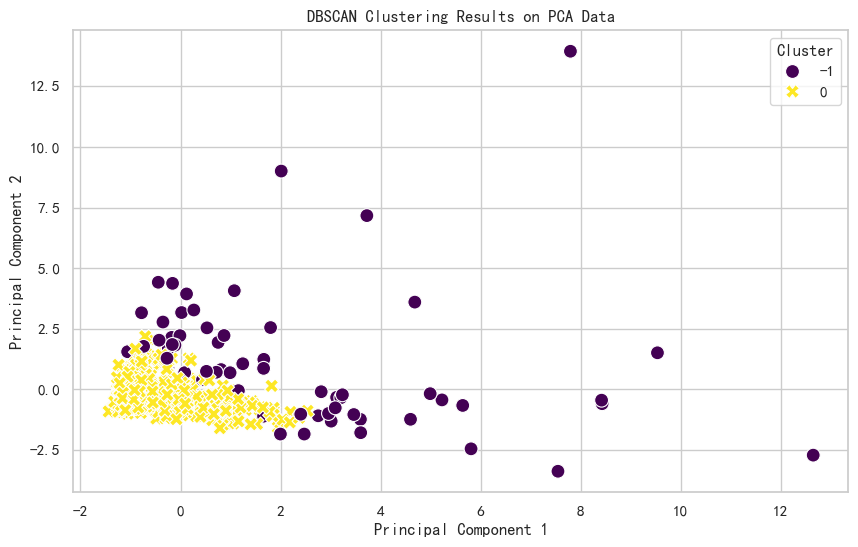

In [21]:
print("\n--- DBSCAN 聚类 ---")
dbscan = DBSCAN(eps=1, min_samples=15)
clusters = dbscan.fit_predict(pcs)

df['Cluster'] = clusters

print("\n聚类结果统计 (Cluster -1 代表噪声点):")
print(pd.Series(clusters).value_counts())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=clusters, palette='viridis', style=clusters, s=100)
plt.title('DBSCAN Clustering Results on PCA Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


### 3. 分类模型

将聚类的结果作为分类的目标，使用逻辑回归和随机森林模型建立分类模型，分析各特征重要程度。


#### PCA作为X的逻辑回归、随机森林

In [22]:
y = clusters
X_model = pcs

X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.3, random_state=42)

print(f"训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")

print("\n--- Logistic Regression ---")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred_lr):0.3f}")
print("\n分类报告:\n", classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred_rf):0.3f}")
print("\n分类报告:\n", classification_report(y_test, y_pred_rf, zero_division=0))


训练集形状: (308, 6), 测试集形状: (132, 6)

--- Logistic Regression ---
accuracy: 0.962

分类报告:
               precision    recall  f1-score   support

          -1       0.93      0.76      0.84        17
           0       0.97      0.99      0.98       115

    accuracy                           0.96       132
   macro avg       0.95      0.88      0.91       132
weighted avg       0.96      0.96      0.96       132


--- Random Forest ---
accuracy: 0.955

分类报告:
               precision    recall  f1-score   support

          -1       0.92      0.71      0.80        17
           0       0.96      0.99      0.97       115

    accuracy                           0.95       132
   macro avg       0.94      0.85      0.89       132
weighted avg       0.95      0.95      0.95       132



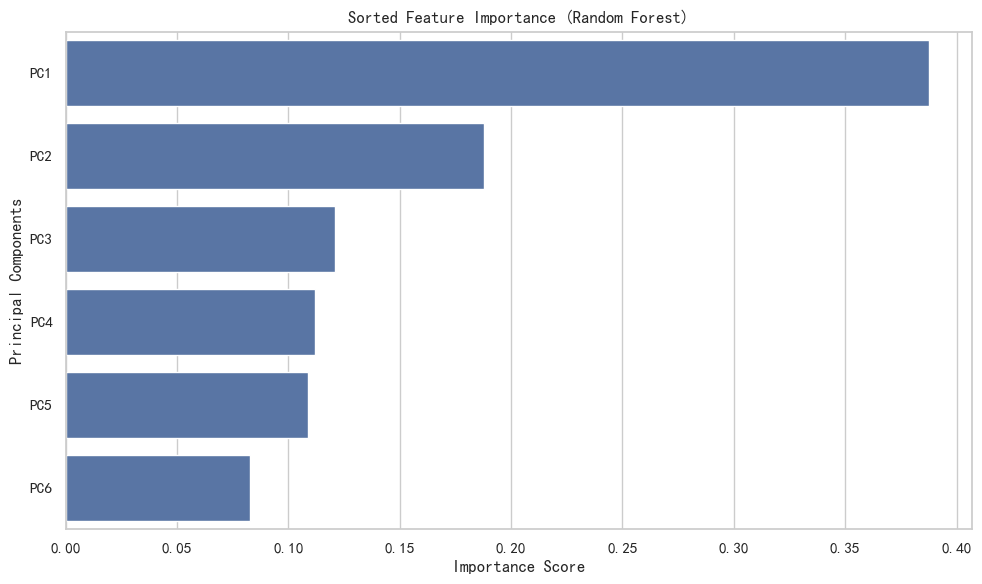

In [23]:
feature_importance_df = pd.DataFrame({
                            'Feature': feature_names,
                            'Importance': rf.feature_importances_
                        }).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

plt.title('Sorted Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()

PC1为

#### 标准化后原数据作为X的随机森林

In [24]:
df.iloc[:, 2:8]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125



--- Random Forest ---
非PCA特征的accuracy: 0.9697


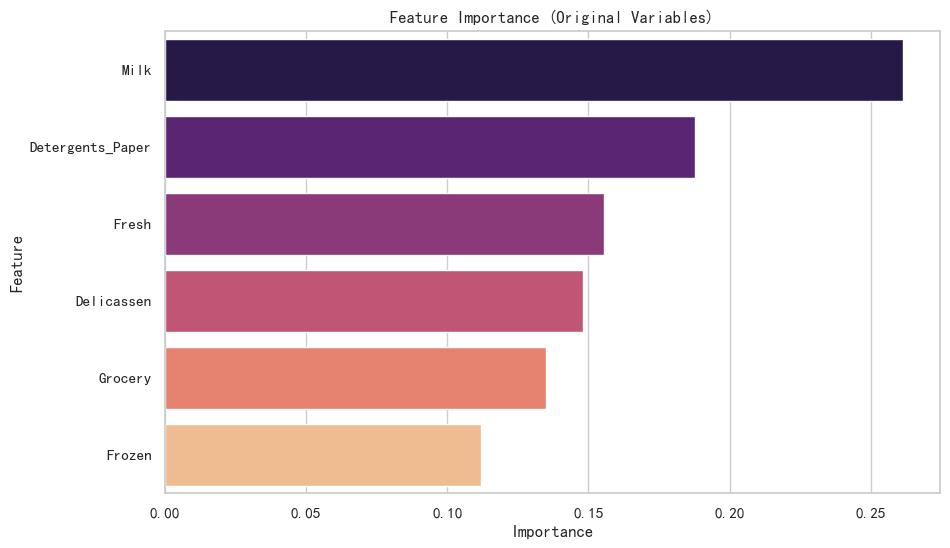

In [25]:
features = df.columns[2:8]

X_orig_train, X_orig_test, y_train, y_test = train_test_split(
    X_scaled,  
    clusters,
    test_size=0.3, 
    random_state=42
)

print("\n--- Random Forest ---")
rf_orig = RandomForestClassifier(n_estimators=100, random_state=42)
rf_orig.fit(X_orig_train, y_train)

print(f"非PCA特征的accuracy: {rf_orig.score(X_orig_test, y_test):.4f}")

importances_orig = rf_orig.feature_importances_
feature_names_orig = features

feat_df = pd.DataFrame({'Feature': feature_names_orig, 'Importance': importances_orig})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, hue='Feature', palette='magma', legend=False)
plt.title('Feature Importance (Original Variables)')
plt.show()